In [76]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA

In [1]:
%pip install opencv-python


  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)
Note: you may need to restart the kernel to use updated packages.


<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red">r1, r2, r3, r4, r5</span>.

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2025 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:
0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 


<div class="alert alert-block alert-info">
<b>NOTE:</b> This notebook is just a example/template, feel free to adjust in any way you please! Just keep things organised and document accordingly!
</div>

<div class="alert alert-block alert-info">
<b>NOTE:</b> Clearly indicate the improvements that you make!!! You can for instance use titles like: <i>3.1. Improvement: Non-linear SVM with RBF Kernel.<i>
</div>
    
---------------------------------------------------------------
# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [83]:
# Input data files are available in the read-only "../input/" directory

train = pd.read_csv(
    'data/train_set.csv', index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(
    'data/test_set.csv', index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load('data/train/train_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load('data/test/test_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]
  

train_size, test_size = len(train),len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

'The training set contains 80 examples, the test set contains 1816 examples.'

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution.

In [ ]:
# The training set contains an identifier, name, image information and class label
train.head(1)

In [ ]:
# The test set only contains an identifier and corresponding image information.

test.head(1)

In [5]:
# The class distribution in the training set:
train.groupby('name').agg({'img':'count', 'class': 'max'})

,img,class
name,,
Jesse_Eisenberg,30,1
Michael_Cera,10,0
Mila_Kunis,30,2
Sarah_Hyland,10,0


Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data
### 0.3.1 Example: HAAR face detector
In this example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one. 

<div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div>


In [ ]:
class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)
    


In [ ]:
### chatgpt ###
def KernelPCARun(X):
    # Using RBF kernel PCA
    kpca = KernelPCA(n_components=100, kernel='rbf', gamma=1e-5, fit_inverse_transform=False)
    X_kpca = kpca.fit_transform(X)  # shape: (n_samples, 100)

    # We chose 100 components arbitrarily here; one might tune gamma and n_components.
    print("Kernel PCA output shape:", X_kpca.shape)
    return X_kpca


def RunPCA(X,threshold = 0.95):
    pca = PCA(n_components=threshold, svd_solver='full')  # keep 95% of variance
    X_pca = pca.fit_transform(X)  # shape: (n_samples, k), k chosen by 95% var criterion

    print("Original dimension:", X.shape[1])
    print("Reduced dimension:", X_pca.shape[1])
    # explained_variance_ratio_ tells us how much variance each PC explains
    cum_var = np.cumsum(pca.explained_variance_ratio_)
    print("Cumulative explained variance:", cum_var)
    return pca,X_pca

def vizualiseEigenFaces(pca):
    eigenfaces = pca.components_[:16]  # top 16 eigenfaces
    h = w = 100  # if images were 100x100 grayscale (D=10000); adjust for actual size
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(4, 4, figsize=(6,6))
    for i, ax in enumerate(axes.flat):
        if i < len(eigenfaces):
            # reshape eigenface into image and show
            ax.imshow(eigenfaces[i].reshape(h, w, -1))  # if color, remove cmap
            ax.set_title(f"PC {i+1}")
            ax.axis('off')
    plt.suptitle("Top 16 Eigenfaces")
    plt.show()

**Visualise**

Let's plot a few examples.

In [ ]:
# parameter to play with 
FACE_SIZE = (100, 100)

def plot_image_sequence(data, n, imgs_per_row=7):
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))

    if n_rows > 1 or n_cols > 1:
        axes = ax.flatten()
    else:
        axes = [ax]

    for i in range(n):
        if n == 1:
            ax.imshow(data[i])
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i])
        else:
            ax[int(i%n)].imshow(data[i])
        axes[i].set_xlabel(f"Index: {i}", fontsize=60)
    plt.show()

#preprocessed data 
preprocessor = HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE)

train_X, train_y = preprocessor(train), train['class'].values
test_X = preprocessor(test)


C:\Users\warrd\AppData\Local\Temp\ipykernel_11912\4005177570.py:53: RuntimeWarning: invalid value encountered in cast
  return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)


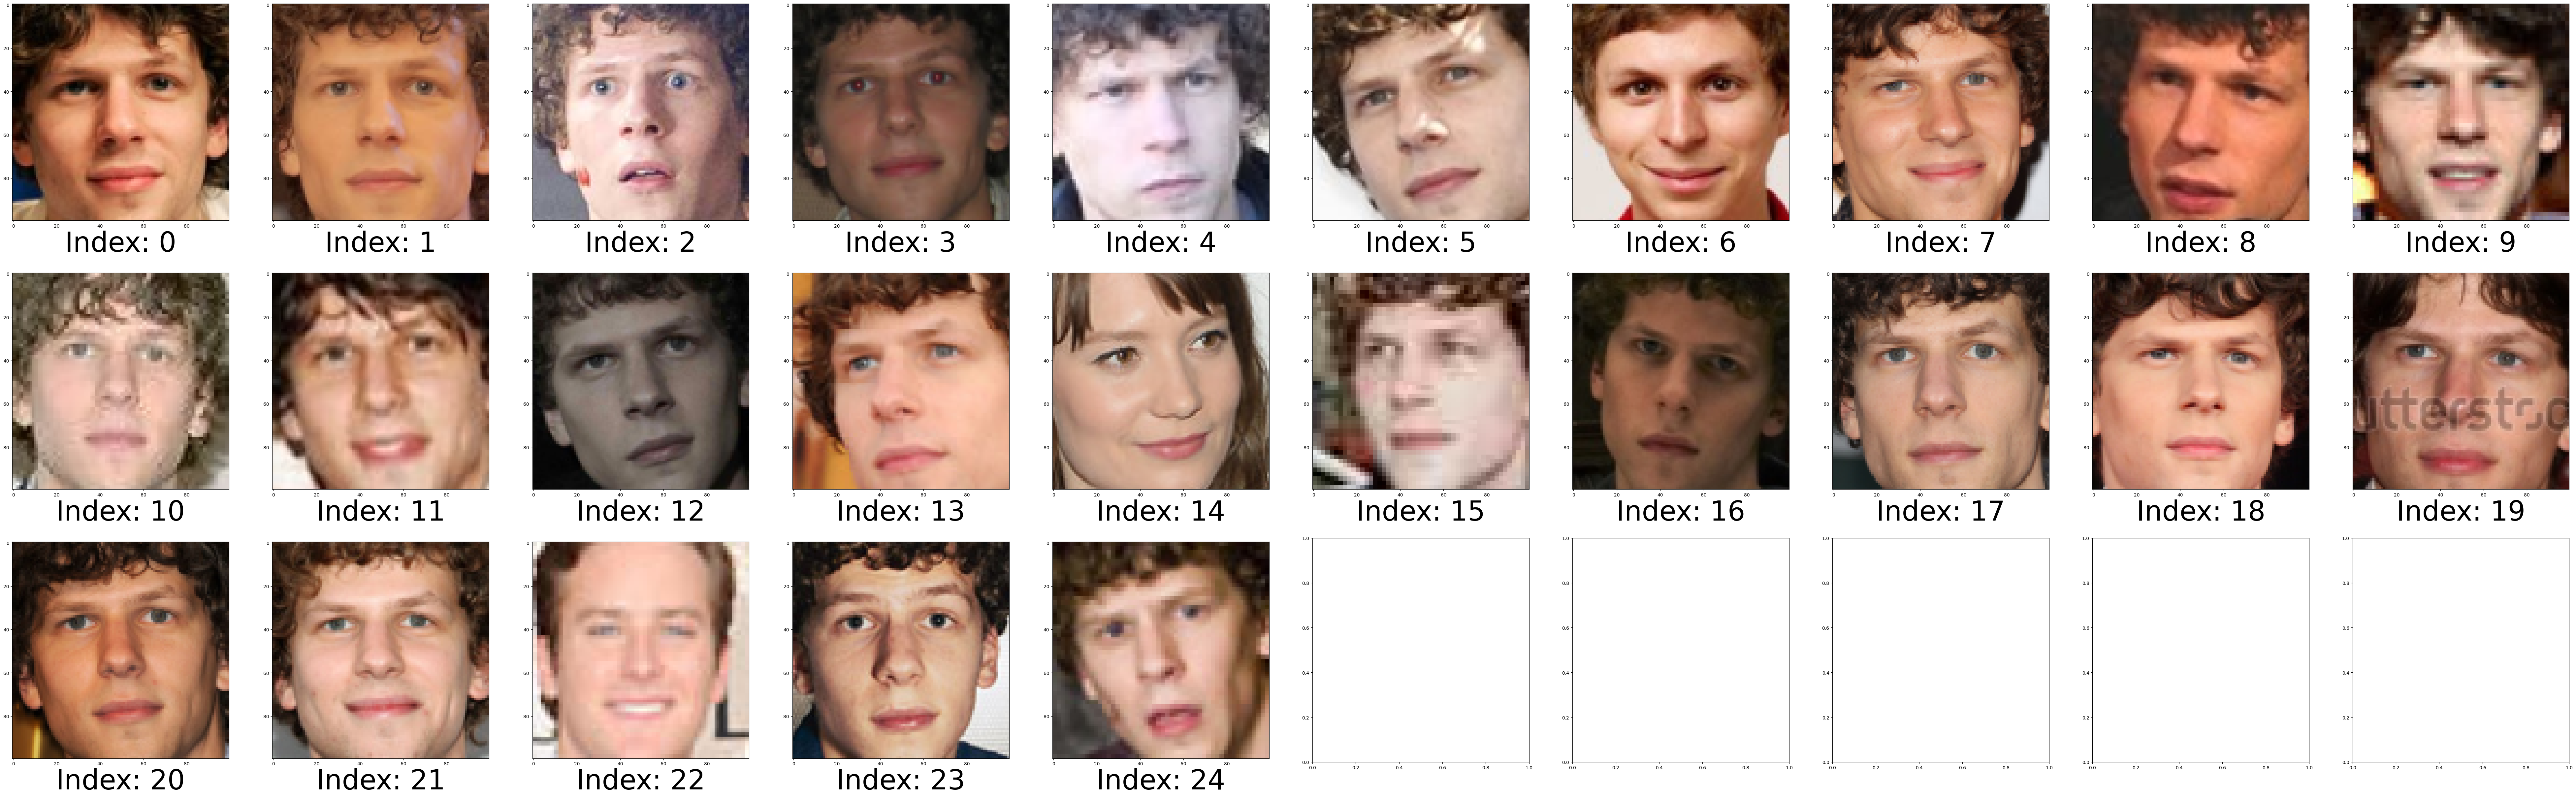

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9223372036854775808..-9223372036854775808].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9223372036854775808..-9223372036854775808].


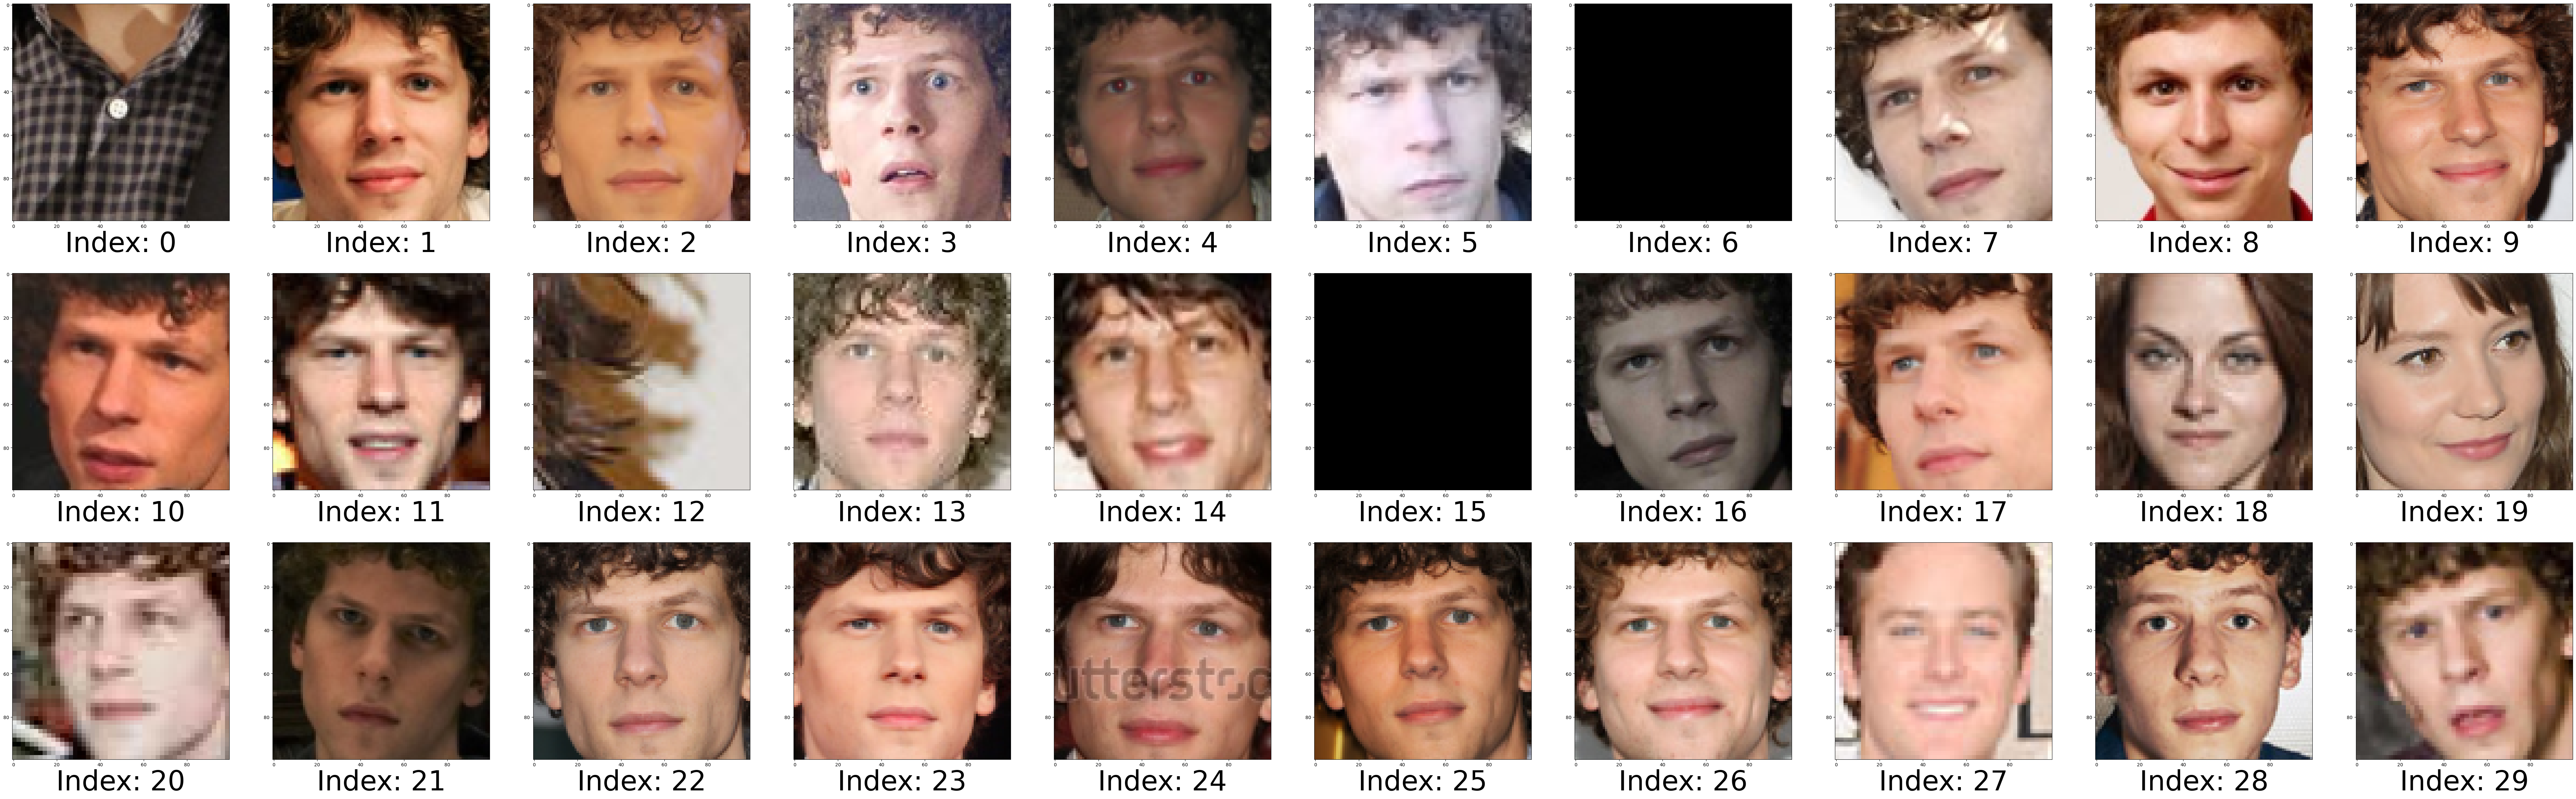

In [ ]:
# code further preprocssing
# manual removal of outliers
IndicesToRemove1 = [0,6,15,12,18] #ind 19,18,26?
IndicesToRemove2 = [5,7,24] # 14,15?
train_X_1        = np.delete(train_X[train_y == 1], IndicesToRemove1, axis=0)
train_X_2        = np.delete(train_X[train_y == 2], IndicesToRemove2, axis=0)
train_X_removed  = np.concatenate((train_X_1, train_X_2, train_X[train_y == 0]))

train_Y_1 = np.delete(train_y[train_y == 1], IndicesToRemove1, axis=0)
train_Y_2 = np.delete(train_y[train_y == 2], IndicesToRemove2, axis=0)
train_Y_removed  = np.concatenate((train_Y_1, train_Y_2, train_y[train_y == 0]))

#code to visualize the removal
plot_image_sequence(train_X_removed[train_Y_removed == 1], n=25, imgs_per_row=10)
plot_image_sequence(train_X[train_y == 1], n=30, imgs_per_row=10)


In [ ]:
# train_Y_removed
train_X_removed_flat = train_X_removed.reshape(train_X_removed.shape[0], -1)

# normalization


pca,X_pca = RunPCA(train_X_removed_flat,threshold = 0.95)
Kpca      = KernelPCARun(train_X_removed_flat)

Original dimension: 30000
Reduced dimension: 45
Cumulative explained variance: [0.22057292 0.40120112 0.47784295 0.53651354 0.57256225 0.60506575
 0.63316585 0.65935126 0.68113494 0.70138257 0.72100574 0.73617494
 0.7501071  0.76313061 0.77489115 0.78582695 0.79592167 0.80587181
 0.81478148 0.82325488 0.83151518 0.83961695 0.84701417 0.85427601
 0.86113434 0.86746462 0.87360298 0.87967481 0.88541323 0.89089854
 0.89609359 0.90111034 0.90603276 0.91079749 0.91519924 0.91953594
 0.9237313  0.92784251 0.93185497 0.93549475 0.93905825 0.94246861
 0.94569781 0.94886984 0.95189105]
Kernel PCA output shape: (72, 72)


## 0.4. Store Preprocessed data (optional)
<div class="alert alert-block alert-info">
<b>NOTE:</b> You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". Feel free to use this to store intermediary results.
</div>

In [ ]:
# save preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
    
# np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
# np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
# np.save(os.path.join(prep_path, 'test_X.npy'), test_X)

# load preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
# train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
# train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
# test_X = np.load(os.path.join(prep_path, 'test_X.npy'))

Now we are ready to rock!

# 1. Feature Representations
## 1.0. Example: Identify feature extractor
Our example feature extractor doesn't actually do anything... It just returns the input:
$$
\forall x : f(x) = x.
$$

It does make for a good placeholder and baseclass ;).

In [ ]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X):
        return self.transform(X)

## 1.1. Baseline 1: HOG feature extractor/Scale Invariant Feature Transform
...

In [ ]:
class HOGFeatureExtractor(IdentityFeatureExtractor):
    """TODO: this feature extractor is under construction"""
    
    def __init__(**params):
        self.params = params
        
    def transform(self, X):
        raise NotImplmentedError

### 1.1.1. t-SNE Plots
...

### 1.1.2. Discussion
...

## 1.2. Baseline 2: PCA feature extractor
...

In [ ]:
class PCAFeatureExtractor(IdentityFeatureExtractor):
    """TODO: this feature extractor is under construction"""
    
    def __init__(self, n_components):
        self.n_components = n_components
        
    def transform(self, X):
        raise NotImplmentedError
        
    def inverse_transform(self, X):
        raise NotImplmentedError

### 1.2.1. Eigenface Plots
...

### 1.2.2. Feature Space Plots
...

### 1.2.3. Discussion
...

# 2. Evaluation Metrics
## 2.0. Example: Accuracy
As example metric we take the accuracy. Informally, accuracy is the proportion of correct predictions over the total amount of predictions. It is used a lot in classification but it certainly has its disadvantages...

In [ ]:
from sklearn.metrics import accuracy_score

# 3. Classifiers
## 3.0. Example: The *'not so smart'* classifier
This random classifier is not very complicated. It makes predictions at random, based on the distribution obseved in the training set. **It thus assumes** that the class labels of the test set will be distributed similarly to the training set.

In [ ]:
class RandomClassificationModel:
    """Random classifier, draws a random sample based on class distribution observed 
    during training."""
    
    def fit(self, X, y):
        """Adjusts the class ratio instance variable to the one observed in y. 

        Parameters
        ----------
        X : tensor
            Training set
        y : array
            Training set labels

        Returns
        -------
        self : RandomClassificationModel
        """
        
        self.classes, self.class_ratio = np.unique(y, return_counts=True)
        self.class_ratio = self.class_ratio / self.class_ratio.sum()
        return self
        
    def predict(self, X):
        """Samples labels for the input data. 

        Parameters
        ----------
        X : tensor
            dataset
            
        Returns
        -------
        y_star : array
            'Predicted' labels
        """

        np.random.seed(0)
        return np.random.choice(self.classes, size = X.shape[0], p=self.class_ratio)
    
    def __call__(self, X):
        return self.predict(X)
    

## 3.1. Baseline 1: My favorite classifier
...

In [ ]:
class FavoriteClassificationModel:
    """TODO: this classifier is under construction."""
    
    def fit(self, X, y):
        raise NotImplmentedError
        
    def predict(self, X):
        raise NotImplmentedError

# 4. Experiments
<div class="alert alert-block alert-info"> <b>NOTE:</b> Do <i>NOT</i> use this section to keep track of every little change you make in your code! Instead, highlight the most important findings and the major (best) pipelines that you've discovered.  
</div>
<br>

## 4.0. Example: basic pipeline
The basic pipeline takes any input and samples a label based on the class label distribution of the training set. As expected the performance is very poor, predicting approximately 1/4 correctly on the training set. There is a lot of room for improvement but this is left to you ;). 

In [ ]:
feature_extractor = IdentityFeatureExtractor() 
classifier = RandomClassificationModel()

# train the model on the features
classifier.fit(feature_extractor(train_X), train_y)

# model/final pipeline
model = lambda X: classifier(feature_extractor(X))

In [ ]:
# evaluate performance of the model on the training set
train_y_star = model(train_X)

"The performance on the training set is {:.2f}. This however, does not tell us much about the actual performance (generalisability).".format(
    accuracy_score(train_y, train_y_star))

In [ ]:
# predict the labels for the test set 
test_y_star = model(test_X)

# 5. Publishing best results

In [ ]:
submission = test.copy().drop('img', axis = 1)
submission['class'] = test_y_star

submission

In [ ]:
submission.to_csv('submission.csv')

# 6. Discussion
...

In summary we contributed the following: 
* 
